# Character Recognition with Semeion Dataset

### Imports

In [1]:
import os
import datetime
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework import dtypes, random_seed

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Helper libraries
import numpy as np
import pandas as pd
import collections
from random import shuffle
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-alpha0


___

### Read the semeion dataset

The semeion dataset consists of 1593 digits from 0 to 9 manuscripts, which were scanned in gray scale and adjusted in a rectangle of 16x16, totaling 256 pixels. Each line in the file consists of the value of 256 pixels (normalized between 0 and 1), followed by the number indication that the 256 pixels represent. This indication is made using 10 values. For example, an entry corresponding to the number 0 is indicated by [1000000000].

The dataset is the object that will contain the data, and it has three attributes: train, test and data. Since train corresponds to 80% of the data scrambled and test corresponds to 20% of the scrambled data, each containing the images and labels. But, the data attribute has all the dataset also separated between images and labels but sorted as it comes in the file.

In [2]:
class DataSet(object):
    def __init__(self, images, labels, reshape = False, seed = None):
        seed1, seed2 = random_seed.get_seed(seed)

        #If op level seed is not set, use whatever graph level seed is returned
        np.random.seed(seed1 if seed is None else seed2)

        assert images.shape[0] == labels.shape[0], ('images.shape: %s labels.shape: %s' % (images.shape, labels.shape))

        self.num_examples = images.shape[0]

        #Convert shape from [num examples, rows, columns, depth] to [num examples, rows*columns](assuming depth == 1)
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])

        self.images = images
        self.labels = labels
        


def read_data_semeion(fname = 'data/semeion.data', test_split=False):
    file = open(fname, 'r')
    lines = file.readlines()

    width = 16
    height = 16
    size = width * height
    classes = 10

    images = [];
    labels = [];
    fnumber = 0;

    for line in lines:
        data = line.split(' ')
        image = [];
        label = [];

        for i in range(0, size):
            image.append(int(float(data[i])))
        images.append(image)

        for i in range(size, size + classes):
            label.append(int(float(data[i]))) 
        labels.append(label)

        fnumber += 1
    

    Datasets = collections.namedtuple('Datasets', ['train', 'test', 'data'])
    
    #Shuffle data
    images_shuffle = []
    labels_shuffle = []
    indexes = list(range(len(images)))
    shuffle(indexes)
    for i in indexes:
        images_shuffle.append(images[i])
        labels_shuffle.append(labels[i])

    images = images_shuffle
    labels = labels_shuffle

    samples = len(lines)
    train_samples = int(0.8*samples)
    test_samples = int(0.2*samples) + 1

    #Train set
    image_train = np.array(images[:train_samples], dtype=np.uint8)
    image_train = image_train.reshape(train_samples, width, height)

    label_train = np.array(labels[:train_samples], dtype=np.uint8)

    train = DataSet(image_train, label_train, reshape=False)

    #test set
    image_test = np.array(images[train_samples:], dtype=np.uint8)
    image_test = image_test.reshape(test_samples, width, height)

    label_test = np.array(labels[train_samples:], dtype=np.uint8)

    test = DataSet(image_test, label_test, reshape=False)

    image_data = np.array(images, dtype=np.uint8)
    image_data = image_data.reshape(samples, width, height)
    data = DataSet(image_data, np.array(labels, dtype=np.uint8))

    return Datasets(train=train, test=test, data=data)


dataset = read_data_semeion()

#### Check the shape of the dataset

In [3]:
dataset.data.images.shape

(1593, 16, 16)

In [4]:
dataset.data.labels.shape

(1593, 10)

In [5]:
dataset.train.images.shape

(1274, 16, 16)

In [6]:
dataset.train.labels.shape

(1274, 10)

In [7]:
dataset.test.images.shape

(319, 16, 16)

In [8]:
dataset.test.labels.shape

(319, 10)

#### Plot some images

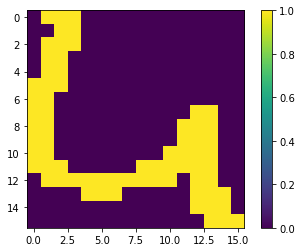

In [9]:
plt.figure()
plt.imshow(dataset.test.images[301])
plt.colorbar()
plt.grid(False)

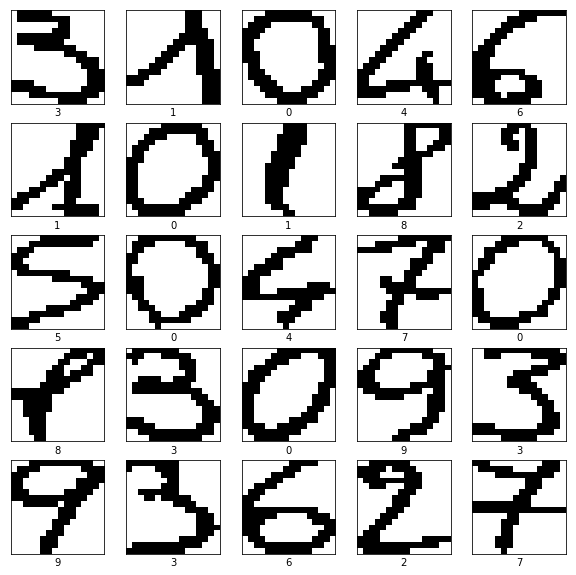

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset.data.images[i], cmap=plt.cm.binary)
    plt.xlabel(np.argmax(dataset.train.labels[i]))
plt.show()

___

### Create the model architecture

For compile the multilayer perceptrons below, the optimizer chose was "adam", because he performs the backpropagation with was require by the professor.

The multi-layer perceptron created below has an input layer that simply transforms images from 16x16 to 256. It has a hidden layer with 64 neurons and an output layer with 10 neurons. The activation functions used were the logistic function (sigmoid).

In [11]:
# Function to create model, required for KerasClassifier
def create_model_1():
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(16, 16)))
    model.add(keras.layers.Dense(64, activation='sigmoid'))
    model.add(keras.layers.Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The multi-layer perceptron created below has an input layer that simply transforms images from 16x16 to 256. It has two hidden layers with 32 neurons each and an output layer with 10 neurons. The activation functions used were the logistic function (sigmoid).

In [12]:
# Function to create model, required for KerasClassifier
def create_model_2():
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(16, 16)))
    model.add(keras.layers.Dense(32, activation='sigmoid'))
    model.add(keras.layers.Dense(32, activation='sigmoid'))
    model.add(keras.layers.Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The multi-layer perceptron created below has an input layer that simply transforms images from 16x16 to 256. It has five hidden layers with 16 neurons each and an output layer with 10 neurons. The activation functions used were the logistic function (sigmoid).

In [13]:
# Function to create model, required for KerasClassifier
def create_model_3():
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(16, 16)))
    model.add(keras.layers.Dense(16, activation='sigmoid'))
    model.add(keras.layers.Dense(16, activation='sigmoid'))
    model.add(keras.layers.Dense(16, activation='sigmoid'))
    model.add(keras.layers.Dense(16, activation='sigmoid'))
    model.add(keras.layers.Dense(16, activation='sigmoid'))
    model.add(keras.layers.Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

To select the neural network that will be used just copy the method of the function that creates the neural network in the first parameter "build_fn" below.

In [14]:
# Wrap Keras model so it can be used by scikit-learn
neural_network_1 = KerasClassifier(build_fn=create_model_1, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=0)

In [15]:
# Wrap Keras model so it can be used by scikit-learn
neural_network_2 = KerasClassifier(build_fn=create_model_2, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=0)

In [16]:
# Wrap Keras model so it can be used by scikit-learn
neural_network_3 = KerasClassifier(build_fn=create_model_3, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=0)

The scores assessed on this problem are accuracy, precision, recall and f1_score.

In [17]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average='weighted'), 
           'f1_score' : make_scorer(f1_score, average='weighted')}

The labels have returned to categorization where a one-hot-embedding is not used. That is, [0100000000] becomes 1.

In [18]:
Y = []
for y in range(len(dataset.data.labels)):
    Y.append(np.argmax(dataset.data.labels[y]))

Here the model is trained using cross-validation with five subsets with the same proportion of classes.

In [19]:
# Evaluate neural network using five-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_results_1 = cross_validate(neural_network_1, dataset.data.images, Y, cv=kfold, scoring=scoring, return_train_score=False)

In [20]:
acc_results_2 = cross_validate(neural_network_2, dataset.data.images, Y, cv=kfold, scoring=scoring, return_train_score=False)

In [21]:
acc_results_3 = cross_validate(neural_network_3, dataset.data.images, Y, cv=kfold, scoring=scoring, return_train_score=False)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results are:

In [22]:
acc_results_1

{'fit_time': array([8.37670803, 7.88378692, 8.69573569, 6.80475807, 7.39157319]),
 'score_time': array([0.04732823, 0.03989339, 0.03989267, 0.04390025, 0.04687452]),
 'test_accuracy': array([0.9504644 , 0.940625  , 0.94670846, 0.91798107, 0.88853503]),
 'test_precision': array([0.95276512, 0.94332504, 0.94885896, 0.91840648, 0.89111451]),
 'test_recall': array([0.9504644 , 0.940625  , 0.94670846, 0.91798107, 0.88853503]),
 'test_f1_score': array([0.95075363, 0.94095165, 0.94699219, 0.91699087, 0.88792766])}

In [23]:
acc_results_2

{'fit_time': array([8.81495667, 7.93708515, 8.32010531, 8.95106506, 8.1073091 ]),
 'score_time': array([0.05027914, 0.05385685, 0.05784535, 0.07978487, 0.05285954]),
 'test_accuracy': array([0.92879257, 0.915625  , 0.90595611, 0.90536278, 0.89171975]),
 'test_precision': array([0.9316195 , 0.91933543, 0.90906155, 0.90669153, 0.89690198]),
 'test_recall': array([0.92879257, 0.915625  , 0.90595611, 0.90536278, 0.89171975]),
 'test_f1_score': array([0.92872227, 0.91574818, 0.90555267, 0.90468016, 0.89147426])}

In [24]:
acc_results_3

{'fit_time': array([10.4323616 , 10.66483974, 10.22502518, 10.62523556, 10.68736601]),
 'score_time': array([0.07480192, 0.07377601, 0.07480049, 0.07183123, 0.07164645]),
 'test_accuracy': array([0.45510836, 0.415625  , 0.30721003, 0.41640379, 0.70063694]),
 'test_precision': array([0.38985874, 0.28038674, 0.22011452, 0.3076314 , 0.71172457]),
 'test_recall': array([0.45510836, 0.415625  , 0.30721003, 0.41640379, 0.70063694]),
 'test_f1_score': array([0.36707308, 0.30478425, 0.21050904, 0.33006086, 0.70198878])}

Transforming the results into a dataset to export to latex.

In [25]:
df_1 = pd.DataFrame(acc_results_1)
df_1.drop(columns=['fit_time', 'score_time'], inplace=True)
columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_1.columns = columns
df_1.head()

,Accuracy,Precision,Recall,F1-Score
0,0.950464,0.952765,0.950464,0.950754
1,0.940625,0.943325,0.940625,0.940952
2,0.946708,0.948859,0.946708,0.946992
3,0.917981,0.918406,0.917981,0.916991
4,0.888535,0.891115,0.888535,0.887928


In [26]:
df_2 = pd.DataFrame(acc_results_2)
df_2.drop(columns=['fit_time', 'score_time'], inplace=True)
columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_2.columns = columns
df_2.head()

,Accuracy,Precision,Recall,F1-Score
0,0.928793,0.931620,0.928793,0.928722
1,0.915625,0.919335,0.915625,0.915748
2,0.905956,0.909062,0.905956,0.905553
3,0.905363,0.906692,0.905363,0.904680
4,0.891720,0.896902,0.891720,0.891474


In [27]:
df_3 = pd.DataFrame(acc_results_3)
df_3.drop(columns=['fit_time', 'score_time'], inplace=True)
columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_3.columns = columns
df_3.head()

,Accuracy,Precision,Recall,F1-Score
0,0.455108,0.389859,0.455108,0.367073
1,0.415625,0.280387,0.415625,0.304784
2,0.307210,0.220115,0.307210,0.210509
3,0.416404,0.307631,0.416404,0.330061
4,0.700637,0.711725,0.700637,0.701989


In [28]:
print(df_1.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &    Recall &  F1-Score \\
\midrule
0 &  0.950464 &   0.952765 &  0.950464 &  0.950754 \\
1 &  0.940625 &   0.943325 &  0.940625 &  0.940952 \\
2 &  0.946708 &   0.948859 &  0.946708 &  0.946992 \\
3 &  0.917981 &   0.918406 &  0.917981 &  0.916991 \\
4 &  0.888535 &   0.891115 &  0.888535 &  0.887928 \\
\bottomrule
\end{tabular}



In [29]:
print(df_2.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &    Recall &  F1-Score \\
\midrule
0 &  0.928793 &   0.931620 &  0.928793 &  0.928722 \\
1 &  0.915625 &   0.919335 &  0.915625 &  0.915748 \\
2 &  0.905956 &   0.909062 &  0.905956 &  0.905553 \\
3 &  0.905363 &   0.906692 &  0.905363 &  0.904680 \\
4 &  0.891720 &   0.896902 &  0.891720 &  0.891474 \\
\bottomrule
\end{tabular}



In [30]:
print(df_3.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &    Recall &  F1-Score \\
\midrule
0 &  0.455108 &   0.389859 &  0.455108 &  0.367073 \\
1 &  0.415625 &   0.280387 &  0.415625 &  0.304784 \\
2 &  0.307210 &   0.220115 &  0.307210 &  0.210509 \\
3 &  0.416404 &   0.307631 &  0.416404 &  0.330061 \\
4 &  0.700637 &   0.711725 &  0.700637 &  0.701989 \\
\bottomrule
\end{tabular}



___

### Analysis of results

In [31]:
val_predict_1 = cross_val_predict(neural_network_1, dataset.data.images, Y, cv=kfold)
val_predict_1

array([3, 1, 0, ..., 2, 7, 0], dtype=int64)

In [32]:
val_predict_2 = cross_val_predict(neural_network_2, dataset.data.images, Y, cv=kfold)
val_predict_2

array([3, 1, 0, ..., 2, 7, 0], dtype=int64)

In [33]:
val_predict_3 = cross_val_predict(neural_network_3, dataset.data.images, Y, cv=kfold)
val_predict_3

array([2, 2, 5, ..., 1, 5, 5], dtype=int64)

Generating the normalized confusion matrix and a classification report

In [34]:
conf_mx_1 = confusion_matrix(Y, val_predict_1)
row_sums = conf_mx_1.sum(axis=1, keepdims=True)
norm_conf_mx_1 = conf_mx_1 / row_sums
np.fill_diagonal(norm_conf_mx_1, 0)

class_rep_1 = classification_report(Y, val_predict_1)

In [35]:
conf_mx_2 = confusion_matrix(Y, val_predict_2)
row_sums = conf_mx_2.sum(axis=1, keepdims=True)
norm_conf_mx_2 = conf_mx_2 / row_sums
np.fill_diagonal(norm_conf_mx_2, 0)

class_rep_2 = classification_report(Y, val_predict_2)

In [36]:
conf_mx_3 = confusion_matrix(Y, val_predict_3)
row_sums = conf_mx_3.sum(axis=1, keepdims=True)
norm_conf_mx_3 = conf_mx_3 / row_sums
np.fill_diagonal(norm_conf_mx_3, 0)

class_rep_3 = classification_report(Y, val_predict_3)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       161
           1       0.89      0.94      0.92       162
           2       0.94      0.94      0.94       159
           3       0.92      0.90      0.91       159
           4       0.96      0.93      0.94       161
           5       0.95      0.92      0.94       159
           6       0.95      0.96      0.96       161
           7       0.94      0.90      0.92       158
           8       0.90      0.89      0.90       155
           9       0.87      0.92      0.90       158

   micro avg       0.93      0.93      0.93      1593
   macro avg       0.93      0.93      0.93      1593
weighted avg       0.93      0.93      0.93      1593



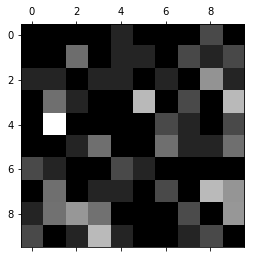

In [37]:
print(class_rep_1)
plt.matshow(norm_conf_mx_1, cmap=plt.cm.gray)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       161
           1       0.88      0.92      0.90       162
           2       0.90      0.89      0.90       159
           3       0.92      0.91      0.91       159
           4       0.91      0.89      0.90       161
           5       0.93      0.92      0.92       159
           6       0.92      0.95      0.93       161
           7       0.92      0.87      0.89       158
           8       0.90      0.86      0.88       155
           9       0.87      0.92      0.90       158

   micro avg       0.91      0.91      0.91      1593
   macro avg       0.91      0.91      0.91      1593
weighted avg       0.91      0.91      0.91      1593



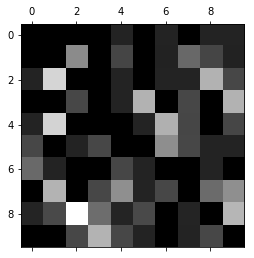

In [38]:
print(class_rep_2)
plt.matshow(norm_conf_mx_2, cmap=plt.cm.gray)

              precision    recall  f1-score   support

           0       0.45      0.35      0.39       161
           1       0.24      0.76      0.36       162
           2       0.46      0.24      0.31       159
           3       0.42      0.33      0.37       159
           4       0.51      0.19      0.27       161
           5       0.33      0.68      0.44       159
           6       0.36      0.28      0.31       161
           7       0.55      0.38      0.45       158
           8       0.59      0.33      0.42       155
           9       0.60      0.15      0.24       158

   micro avg       0.37      0.37      0.37      1593
   macro avg       0.45      0.37      0.36      1593
weighted avg       0.45      0.37      0.36      1593



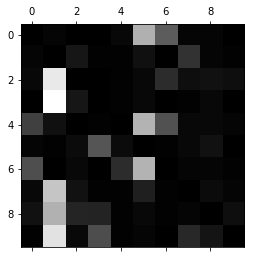

In [39]:
print(class_rep_3)
plt.matshow(norm_conf_mx_3, cmap=plt.cm.gray)

____

### Saving the tensorflow model

To save the model in lite format of tensorflow it was necessary to fit the network again. After the adjustment, the model was saved in the format of the tensorflow lite to be read and performed the statistical inference on the client's cell phone.

In [40]:
model_save = create_model_2()
model_save.fit(dataset.data.images, dataset.data.labels, epochs=100, batch_size=64)

Epoch 1/100
1593/1593 [==============================] - 0s 155us/sample - loss: 2.3242 - accuracy: 0.0973
Epoch 2/100
1593/1593 [==============================] - 0s 80us/sample - loss: 2.2551 - accuracy: 0.2505
Epoch 3/100
1593/1593 [==============================] - 0s 78us/sample - loss: 2.2017 - accuracy: 0.4313
Epoch 4/100
1593/1593 [==============================] - 0s 89us/sample - loss: 2.1394 - accuracy: 0.6573
Epoch 5/100
1593/1593 [==============================] - 0s 79us/sample - loss: 2.0628 - accuracy: 0.7376
Epoch 6/100
1593/1593 [==============================] - 0s 72us/sample - loss: 1.9693 - accuracy: 0.7495
Epoch 7/100
1593/1593 [==============================] - 0s 69us/sample - loss: 1.8621 - accuracy: 0.7746
Epoch 8/100
1593/1593 [==============================] - 0s 71us/sample - loss: 1.7458 - accuracy: 0.7928
Epoch 9/100
1593/1593 [==============================] - 0s 73us/sample - loss: 1.6263 - accuracy: 0.8060
Epoch 10/100
1593/1593 [=====================

In [41]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model_save(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model_save.inputs[0].shape, model_save.inputs[0].dtype))

# Convert the model.
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()

open("semeion.tflite", "wb").write(tflite_model)